In [1]:
import pandas as pd
import numpy as np
from librosa.util import find_files
import librosa
import os
import pickle
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from dataset import ASVspoof2019
from evaluate_tDCF_asvspoof19 import compute_eer_and_tdcf
from collections import defaultdict
from utils import visualize

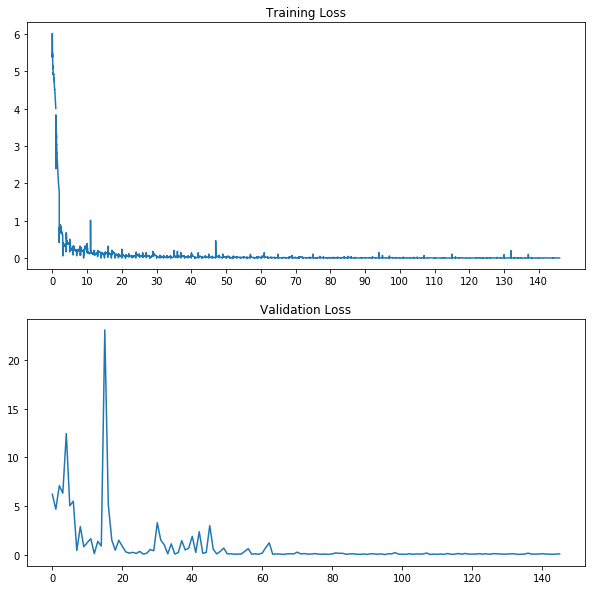

In [2]:
out_fold = "/home/neil/AIR-ASVspoof/models1004/iso_loss3"
train_log_file = os.path.join(out_fold, "train_loss.log")
dev_log_file = os.path.join(out_fold, "dev_loss.log")
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 10))
with open(train_log_file, "r") as train_log:
    x = np.array([[float(i) for i in line[0:-1].split('\t')] for line in train_log.readlines()[1:]])
    ax1.plot(x[:, 2])
    ax1.set_xticks(np.where(x[:,1]==0)[0][::10])
    ax1.set_xticklabels(np.arange(np.sum(x[:,1]==0))*10)
    ax1.set_title("Training Loss")
with open(dev_log_file, "r") as dev_log:
    x = np.array([[float(i) for i in line[0:-1].split('\t')] for line in dev_log.readlines()[1:]])
    ax2.plot(x[:, 1])
    ax2.set_title("Validation Loss")
    plt.show()

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
from tqdm import tqdm
def test_checkpoint_model(feat_model_path, loss_model_path, part, add_loss, visualize=False):
    dirname=os.path.dirname
    basename = os.path.splitext(os.path.basename(feat_model_path))[0]
    if "checkpoint" in dirname(feat_model_path):
        dir_path = dirname(dirname(feat_model_path))
        epoch_num = int(basename.split("_")[-1])
    else:
        dir_path = dirname(feat_model_path)
        epoch_num = 0
    model = torch.load(feat_model_path)
    loss_model = torch.load(loss_model_path) if add_loss is not None else None
    test_set = ASVspoof2019("/data/neil/DS_10283_3336/", "/dataNVME/neil/ASVspoof2019Features/", 
                            "/data/neil/DS_10283_3336/LA/ASVspoof2019_LA_cm_protocols/", part,
                            "Melspec", feat_len=750, pad_chop=False)
    testDataLoader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=0,
                                collate_fn=test_set.collate_fn)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ip1_loader, tag_loader, idx_loader = [], [], []
    model.eval()
    with open(os.path.join(dir_path, 'checkpoint_cm_score.txt'), 'w') as cm_score_file:
        for i, (cqcc, audio_fn, tags, labels) in enumerate(tqdm(testDataLoader)):
            cqcc = cqcc.unsqueeze(1).float().to(device)
            feats, cqcc_outputs = model(cqcc)
            ip1_loader.append(feats.detach().cpu())
            tags = tags.to(device)
            tag_loader.append(tags.detach().cpu())
            labels = labels.to(device)
            idx_loader.append(labels.detach().cpu())
            for j in range(labels.size(0)):
                if add_loss == "isolate":
                    score = torch.norm(feats[j].unsqueeze(0) - loss_model.center, p=2, dim=1).data.item()
                elif add_loss == "ang_iso":
                    score = F.normalize(feats[j].unsqueeze(0), p=2, dim=1) @ F.normalize(loss_model.center, p=2, dim=1).T
                    score = score.data.item()
                elif add_loss == "multi_isolate":
                    genuine_dist = torch.norm((feats[j].unsqueeze(0).repeat(args.num_centers, 1) - loss_model.centers), p=2, dim=1)
                    score, indices = torch.min(genuine_dist, dim=-1)
                    score = score.item()
                elif add_loss == "multicenter_isolate":
                    score = 1e8
                    for k in range(loss_model.centers.shape[0]):
                        dist = torch.norm(feats[j] - loss_model.centers[k].unsqueeze(0), p=2, dim=1)
                        if dist.item() < score:
                            score = dist.item()
                else:
                    score = cqcc_outputs.data[j][0].cpu().numpy()
                cm_score_file.write(
                    '%s A%02d %s %s\n' % (audio_fn[j], tags[j].data,
                                          "spoof" if labels[j].data.cpu().numpy() else "bonafide",
                                          score))
    eer_cm, min_tDCF = compute_eer_and_tdcf(os.path.join(dir_path, 'checkpoint_cm_score.txt'), "/data/neil/DS_10283_3336/")
    
    if visualize:
        feat = torch.cat(ip1_loader, 0)
        labels = torch.cat(idx_loader, 0)
        tags = torch.cat(tag_loader, 0)
        if add_loss == "isolate":
            centers = loss_model.center
        elif add_loss == "multi_isolate":
            centers = loss_model.centers
        elif add_loss == "ang_iso":
            centers = loss_model.center
        else:
            centers = torch.mean(feat[labels == 0], dim=0, keepdim=True)
        torch.save(feat, os.path.join(dir_path, 'feat_%d.pt' % epoch_num))
        torch.save(tags, os.path.join(dir_path, 'tags_%d.pt' % epoch_num))
        visualize(feat.data.cpu().numpy(), tags.data.cpu().numpy(), labels.data.cpu().numpy(), 
                  centers.data.cpu().numpy(), epoch_num, part, dir_path)
    
    return eer_cm, min_tDCF

In [4]:
# test_checkpoint_model(feat_model_path, loss_model_path, "eval", "isolate")

100%|██████████| 8905/8905 [04:38<00:00, 31.93it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            = 22.63892 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.25339


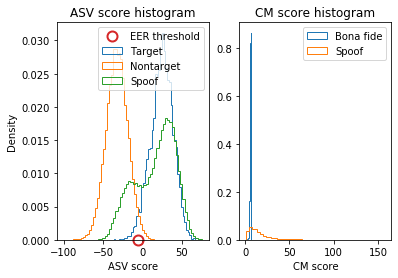

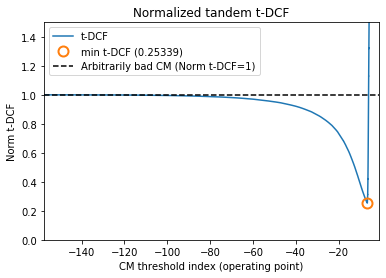

100%|██████████| 8905/8905 [04:39<00:00, 31.81it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            = 14.08237 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.15443


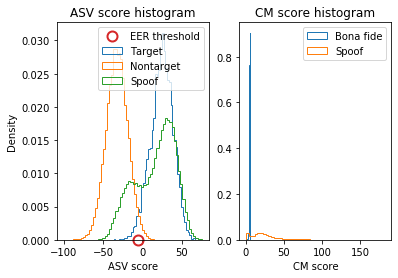

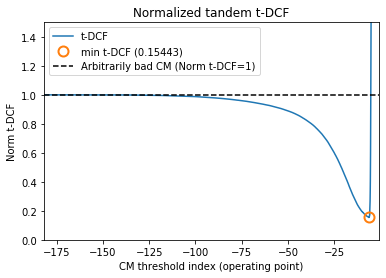

100%|██████████| 8905/8905 [04:39<00:00, 31.82it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  3.00437 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.07997


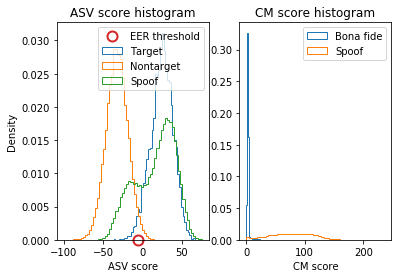

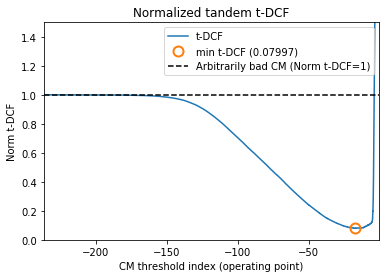

100%|██████████| 8905/8905 [04:39<00:00, 31.82it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  5.51980 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.11733


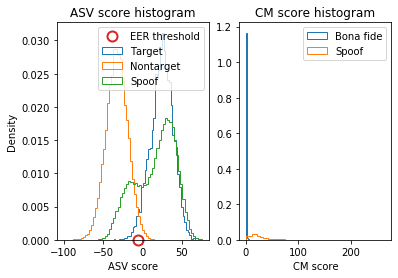

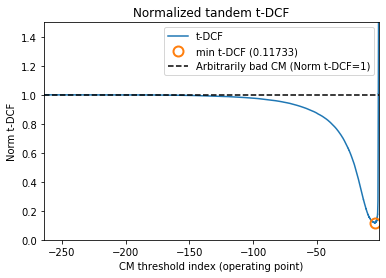

100%|██████████| 8905/8905 [04:40<00:00, 31.76it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            = 40.16392 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.47822


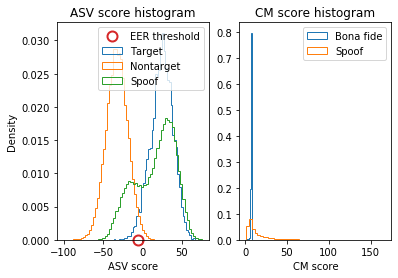

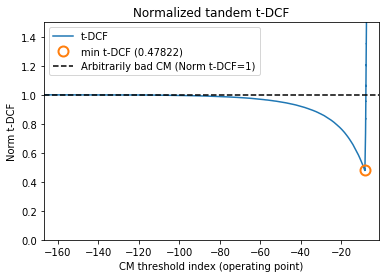

100%|██████████| 8905/8905 [04:41<00:00, 31.64it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            = 10.63451 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.12365


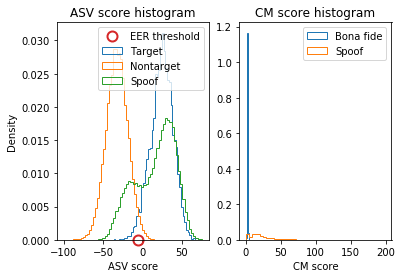

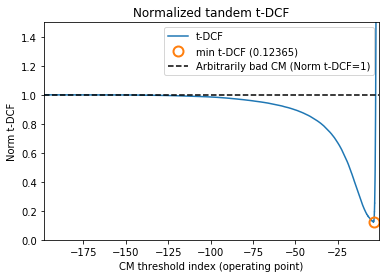

100%|██████████| 8905/8905 [04:41<00:00, 31.64it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  2.87064 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.06005


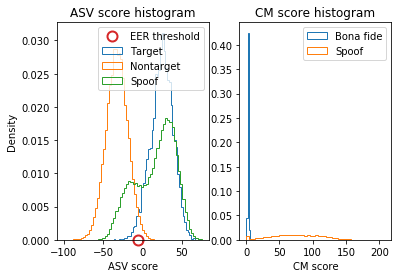

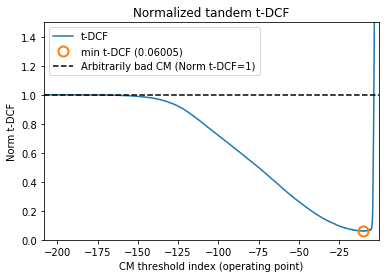

100%|██████████| 8905/8905 [04:41<00:00, 31.66it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            = 19.25088 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.21161


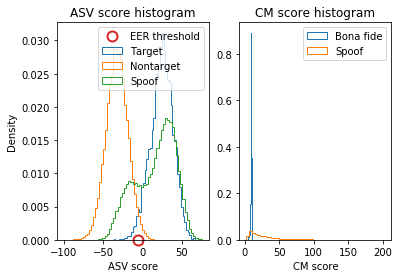

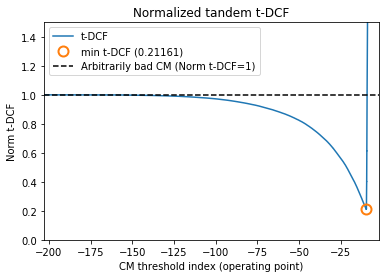

100%|██████████| 8905/8905 [04:41<00:00, 31.68it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  8.85169 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.10670


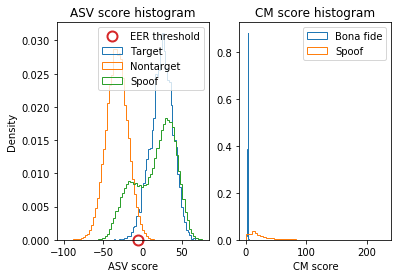

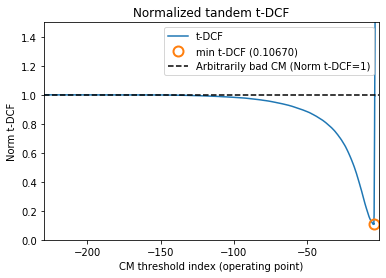

100%|██████████| 8905/8905 [04:41<00:00, 31.66it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            = 40.43528 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.60684


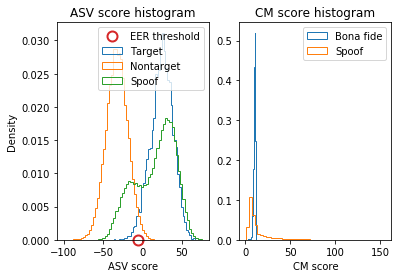

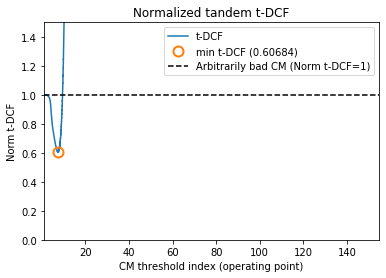

100%|██████████| 8905/8905 [04:41<00:00, 31.64it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            = 49.84512 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.56076


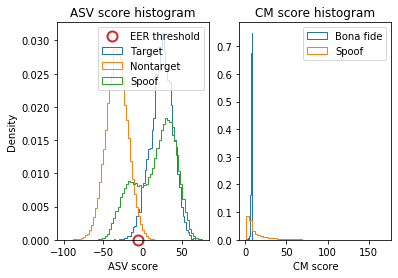

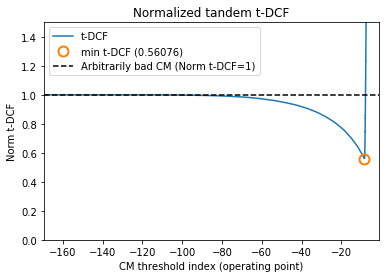

100%|██████████| 8905/8905 [04:41<00:00, 31.60it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  9.38371 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.11014


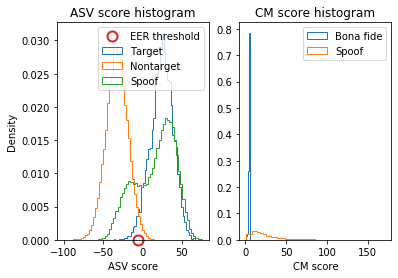

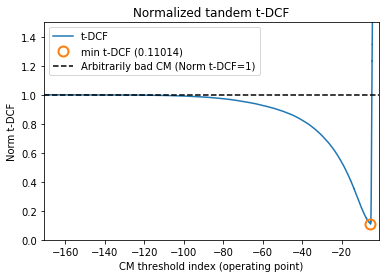

100%|██████████| 8905/8905 [04:42<00:00, 31.54it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  5.19072 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.07552


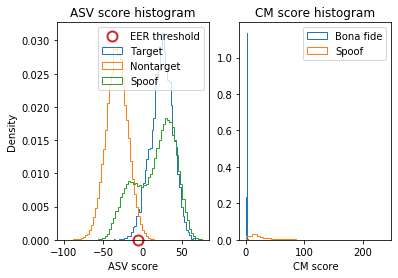

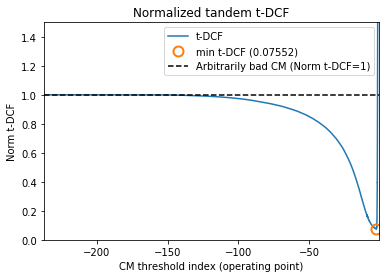

100%|██████████| 8905/8905 [04:42<00:00, 31.57it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            = 19.46688 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.21535


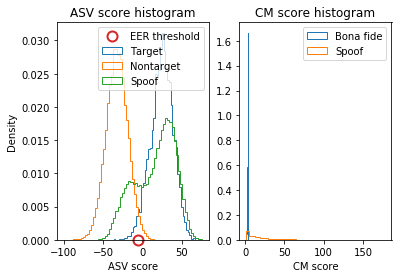

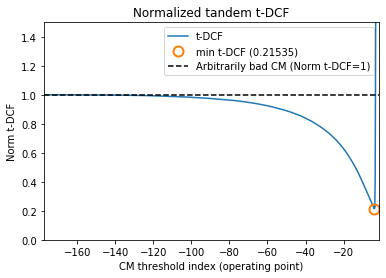

100%|██████████| 8905/8905 [04:42<00:00, 31.56it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            = 35.65201 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.38649


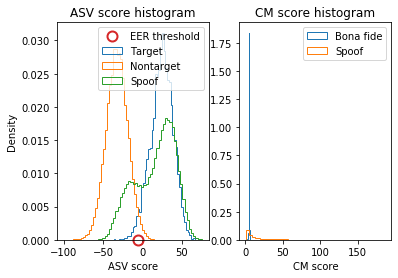

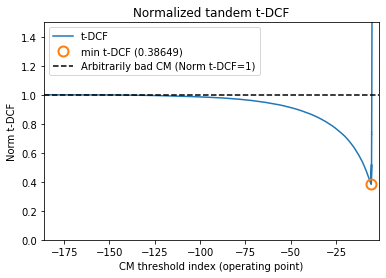

100%|██████████| 8905/8905 [04:42<00:00, 31.57it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            = 13.51351 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.15619


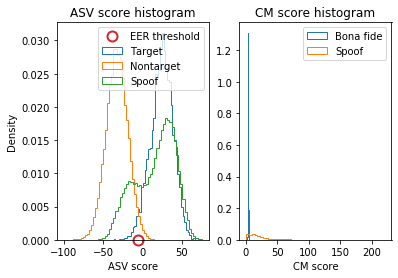

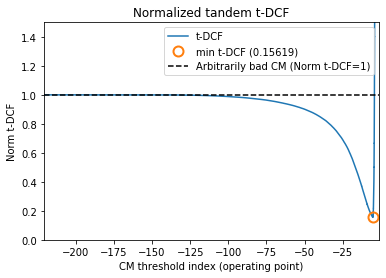

In [5]:
a, b = [], []
for i in range(24,56,2):
    feat_model_path = "/home/neil/AIR-ASVspoof/models0930/iso_hyper2/checkpoint/anti-spoofing_cqcc_model_%d.pt" % i
    loss_model_path = "/home/neil/AIR-ASVspoof/models0930/iso_hyper2/checkpoint/anti-spoofing_loss_model_%d.pt" % i
    eer, tdcf = test_checkpoint_model(feat_model_path, loss_model_path, "eval", "isolate")
    a.append(eer)
    b.append(tdcf)

In [6]:
a

[0.2263892089364034,
 0.14082369663083988,
 0.030043673742361186,
 0.05519803029085046,
 0.4016391647150419,
 0.10634511037951921,
 0.028706401893140377,
 0.19250881623155847,
 0.08851690269093396,
 0.4043528430680028,
 0.49845117967013064,
 0.09383714377700678,
 0.05190717777132042,
 0.1946688012106618,
 0.35652009629157566,
 0.13513514709979702]

In [7]:
b

[0.2533934160915041,
 0.15442921438830728,
 0.07997490937997806,
 0.11733050543010498,
 0.47822499087061116,
 0.12365162059781883,
 0.06005497449516997,
 0.21160792920686203,
 0.10669800090520398,
 0.6068391897756057,
 0.5607602209291849,
 0.11014233785776686,
 0.07551502082938262,
 0.2153508163005717,
 0.38649336067744244,
 0.15619487252924333]

100%|██████████| 8905/8905 [05:05<00:00, 29.14it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  2.16180 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.06133


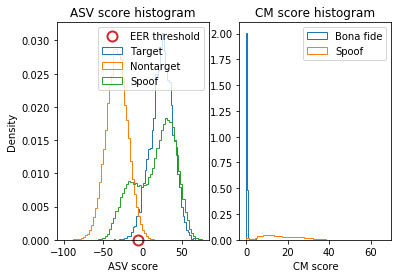

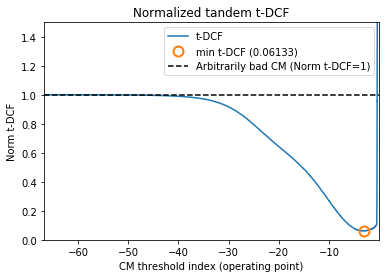

100%|██████████| 8905/8905 [05:22<00:00, 27.65it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  1.85047 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.05505


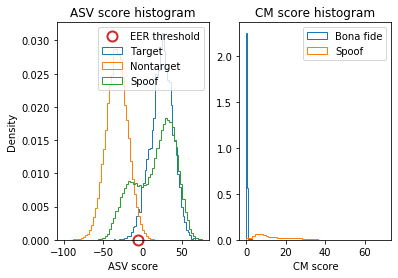

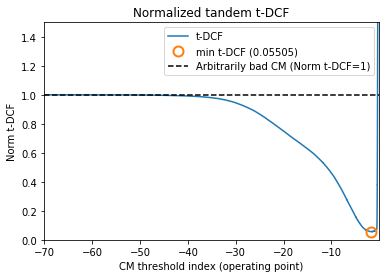

100%|██████████| 8905/8905 [05:24<00:00, 27.41it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  2.86907 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.07542


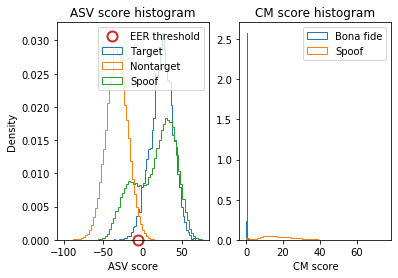

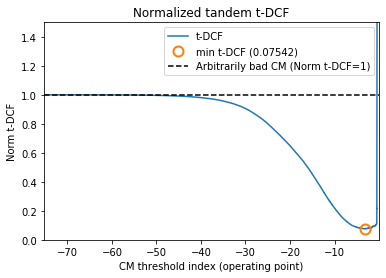

100%|██████████| 8905/8905 [05:27<00:00, 27.16it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  2.31171 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.05763


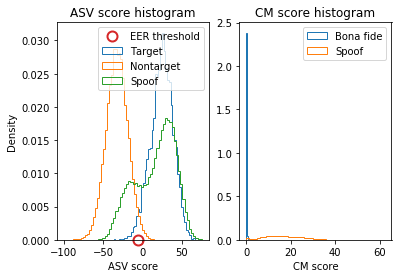

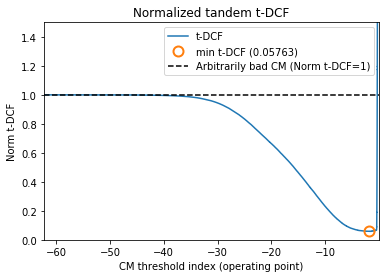

100%|██████████| 8905/8905 [05:20<00:00, 27.82it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  2.20567 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.06201


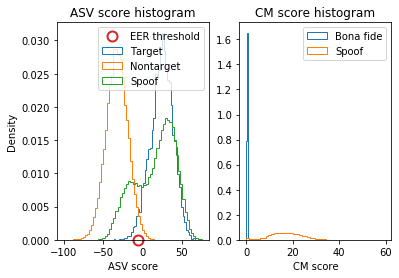

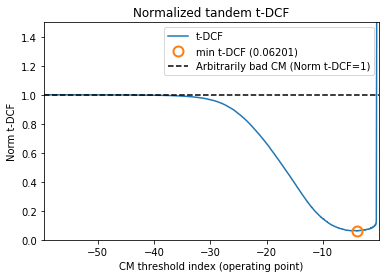

100%|██████████| 8905/8905 [05:30<00:00, 26.96it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  2.33862 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.07029


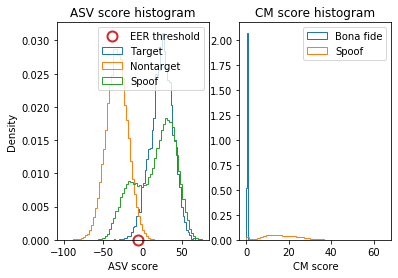

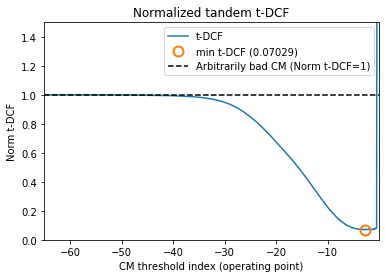

100%|██████████| 8905/8905 [05:29<00:00, 27.02it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  2.21560 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.05718


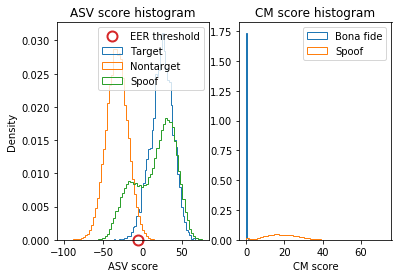

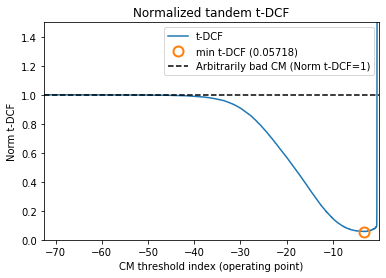

100%|██████████| 8905/8905 [05:23<00:00, 27.52it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  1.94423 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.05713


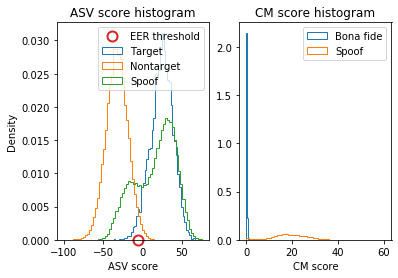

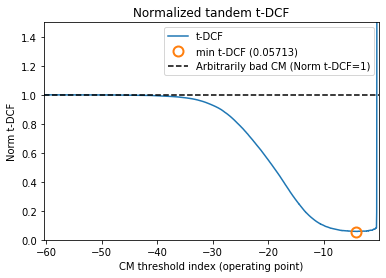

100%|██████████| 8905/8905 [05:24<00:00, 27.42it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  2.70531 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.07465


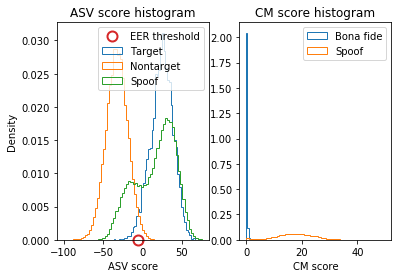

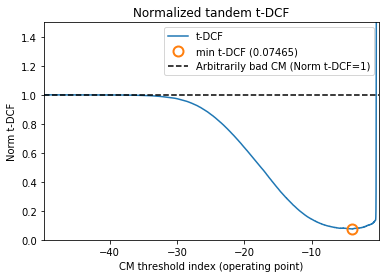

In [6]:
for i in range(43,60,2):
    feat_model_path = "/home/neil/AIR-ASVspoof/models0921/iso_loss_best/checkpoint/anti-spoofing_cqcc_model_%d.pt" % i
    loss_model_path = "/home/neil/AIR-ASVspoof/models0921/iso_loss_best/checkpoint/anti-spoofing_loss_model_%d.pt" % i
    test_checkpoint_model(feat_model_path, loss_model_path, "eval", "isolate")

100%|██████████| 8905/8905 [04:46<00:00, 31.10it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  9.55975 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.20391


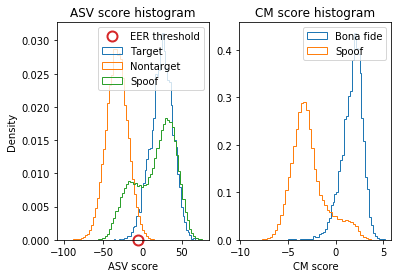

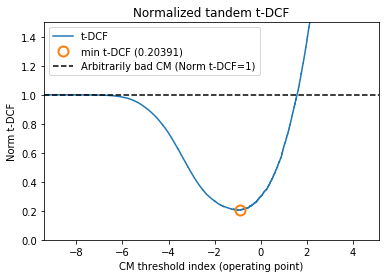

100%|██████████| 8905/8905 [05:12<00:00, 28.50it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  4.71798 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.11340


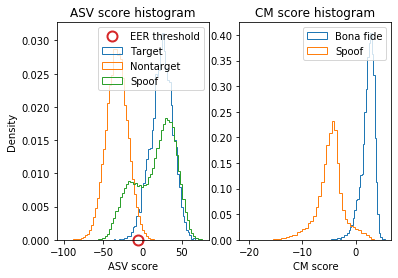

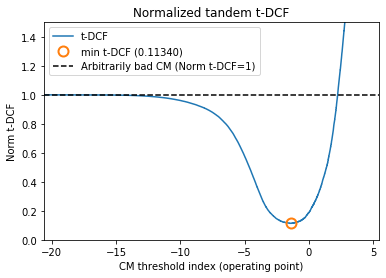

 91%|█████████ | 8076/8905 [04:44<00:28, 28.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 8905/8905 [05:15<00:00, 28.19it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  2.46085 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.07007


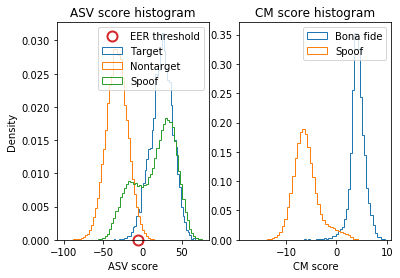

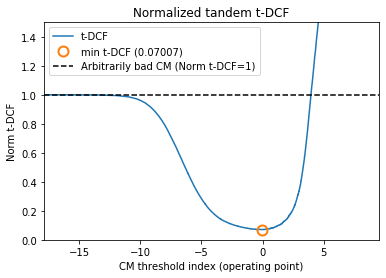

 69%|██████▉   | 6185/8905 [03:34<01:52, 24.27it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 8905/8905 [05:14<00:00, 28.33it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  2.34933 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.06923


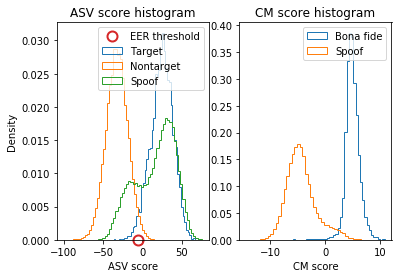

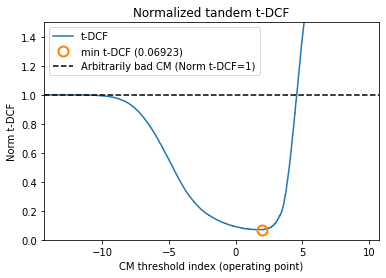

 66%|██████▋   | 5920/8905 [03:26<01:51, 26.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 8905/8905 [05:14<00:00, 28.35it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  1.94658 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.05628


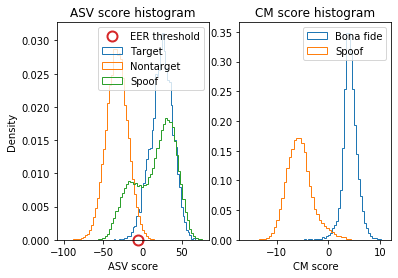

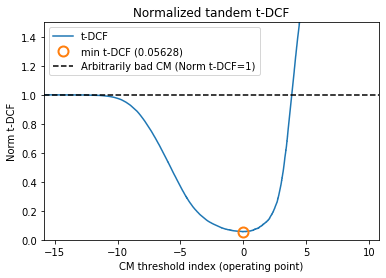

 77%|███████▋  | 6894/8905 [04:03<01:14, 26.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 8905/8905 [05:06<00:00, 29.04it/s]


t-DCF evaluation from [Nbona=7355, Nspoof=63882] trials

   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)


CM SYSTEM
   EER            =  2.54312 % (Equal error rate for countermeasure)

TANDEM
   min-tDCF       =  0.07340


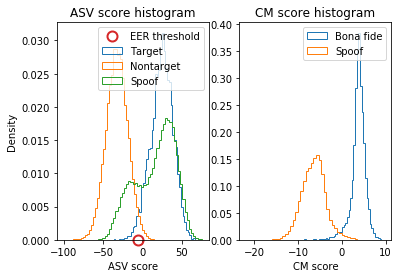

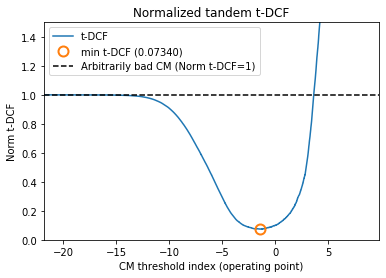

In [9]:
for i in range(1,45,2):
    feat_model_path = "/home/neil/AIR-ASVspoof/models0922/baseline_ce/checkpoint/anti-spoofing_cqcc_model_%d.pt" % i
    loss_model_path = "/home/neil/AIR-ASVspoof/models0922/baseline_ce/checkpoint/anti-spoofing_loss_model_%d.pt" % i
    test_checkpoint_model(feat_model_path, loss_model_path, "eval", None)